# Implementation of the Newmark-β time-stepping

In this notebook, we present an  implementation of the Newmark-β time-stepping technique, see also [Jérémy Bleyer's code](https://comet-fenics.readthedocs.io/en/latest/demo/elastodynamics/demo_elastodynamics.py.html). We adopt here an approach that is more “matrix-oriented”: `FEniCS` is used to assemble the matrices of the problem, discretized in space. Once these matrices are assembled, we write the various linear algebra operations in a detailed manner. 

We consider a cantilever beam of size `Lx × Ly` (2D, plane stress), fixed at its `x = 0` end, and subjected to a transversal load at `x = Lx` as in the precedent class session. 

Introduction and elastodynamics equation
----------------------------------------

The elastodynamics equation combine the balance of linear momentum:

$$\nabla \cdot \sigma + \rho b = \rho \ddot{u}$$

where $u$ is the displacement vector field,
$\ddot{u}=\partial^2 u/\partial t^2$ is the acceleration, $\rho$ the
material density, $b$ a given body force and $\sigma$ the stress tensor
which is related to the displacement through a constitutive equation. In
the case of isotropic linearized elasticity, one has:

$$\sigma =\lambda \text{tr}(\varepsilon)\mathbb{1} + 2\mu\varepsilon$$

where $\varepsilon = (\nabla u + (\nabla u)^T)/2$ is the linearized
strain tensor, $\mathbb{1}$ is the identity of second-rank tensors and
$\lambda=\dfrac{E\nu}{(1+\nu)(1-2\nu)},\mu=\dfrac{E}{2(1+\nu)}$ are the
Lame coefficients given as functions of the Young modulus $E$ and the
Poisson ratio $\nu$.

The weak form is readily obtained by integrating by part the balance
equation using a test function $v\in V$ with $V$ being a suitable
function space that satisfies the displacement boundary conditions:

$$\int_{\Omega} \rho \ddot{u}\cdot v \, {\rm d} x + \int_{\Omega} \sigma(u):\varepsilon(v) \, {\rm d} x =
\int_{\Omega} \rho b \cdot v  \, {\rm d} x 
+ \int_{\partial\Omega} (\sigma\cdot n) \cdot v \, {\rm d} s \quad \text{for all } v \in V
$$

The previous equation can be written as follows:

$$
\text{Find }u\in V\text{ such that } m(\ddot{u},v) + k(u,v) = L(v) \quad \text{for all } v\in V
$$

where $m$ is the symmetric bilinear form associated with the mass matrix
and $k$ the one associated with the stiffness matrix.

After introducing the finite element space interpolation, one obtains
the corresponding discretized evolution equation:

$$\text{Find }\{u\}\in\mathbb{R}^n\text{ such that } \{v\}^T[M]\{\ddot{u}\} + \{v\}^T[K]\{u\} = \{v\}^T\{F\} \quad \text{for all } \{v\}\in\mathbb{R}^n$$

which is a generalized $n$-dof harmonic oscillator equation. Note that only linear problems are considered in this notebook but the method presented below can also be used to solve nonlinear problems.

Quite often in structural dynamics, structures do not oscillate
perfectly but lose energy through various dissipative mechanisms
(friction with air or supports, internal dissipation through plasticity,
damage, etc.). Dissipative terms can be introduced at the level of the
constitutive equation if these mechanisms are well known but quite often
it is not the case. Dissipation can then be modeled by adding an *ad
hoc* damping term depending on the structure velocity $\dot{u}$ to the
previous evolution equation:

$$\text{Find }u\in V\text{ such that } m(\ddot{u},v) + c(\dot{u},v) + k(u,v) = L(v) \quad \text{for all } v\in V$$

The damping form will be considered here as bilinear and symmetric,
being therefore associated with a damping matrix $[C]$.

### Rayleigh damping

When little is known about the origin of damping in the structure, a
popular choice for the damping matrix, known as *Rayleigh damping*,
consists in using a linear combination of the mass and stiffness matrix
$[C] = \eta_M[M]+\eta_K[K]$ with two positive parameters $\eta_M,\eta_K$
which can be fitted against experimental measures for instance (usually
by measuring the damping ratio of two natural modes of vibration).


In [1]:
import dolfin
import os
import numpy as np
import matplotlib.pyplot as plt
import time
dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["optimize"] = True

## Parameters of the simulation

### Geometry

In [2]:
Lx = 1.0
Ly = 0.1
Ny = 4 # Number of elements in the y-direction

### Material parameters

In [3]:
E  = 1000.
nu = 0.3
rho   = dolfin.Constant(1.)
eta_m = dolfin.Constant(0.)
eta_k = dolfin.Constant(0.)

### Loading parameters

A time-dependent traction is applied at the $x = L_x$ face as follows
\begin{equation}
\vec T = \begin{cases}
\displaystyle\frac{t}{t_{\mathrm{c}}}\vec T_{\mathrm{max}} & t \leq t_{\mathrm{c}}\\[.2em]
\vec 0 & t > t_{\mathrm{c}}
\end{cases}
\end{equation}
where $t_{\mathrm{c}}$ is a “cut-off” time. Note that depending on the direction of the applied traction, we will need to select different values for `t_c` and `T_max`.

In [4]:
t_c   = 0.1
T_max = 1
traction = dolfin.Expression((0, "t <= t_c ? T_max*t/t_c : 0"), t=0, t_c=t_c, T_max=T_max, degree=0)

In [5]:
t_end     =   4. # End of simulation
num_steps = 100  # Total number of steps
dt = t_end/num_steps

## Mesh generation

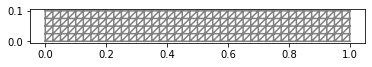

In [6]:
p1 = dolfin.Point(0., 0.)
p2 = dolfin.Point(Lx, Ly)

Nx   = int(Ny*Lx/Ly) # have good proportionality between Nx and Ny
mesh = dolfin.RectangleMesh(p1, p2, Nx, Ny)
dolfin.plot(mesh)

In [7]:
left   = dolfin.CompiledSubDomain("on_boundary && near(x[0], 0)")
right  = dolfin.CompiledSubDomain("on_boundary && near(x[0], L)", L=p2.x())
top    = dolfin.CompiledSubDomain("on_boundary && near(x[1], H)", H=p2.y())
bottom = dolfin.CompiledSubDomain("on_boundary && near(x[1], 0)")

boundary_indices = {"left": 0, "right": 1, "top": 2, "bottom": 3}
boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)

left.mark  (boundary_markers, boundary_indices["left"]  )
right.mark (boundary_markers, boundary_indices["right"] )
top.mark   (boundary_markers, boundary_indices["top"]   )
bottom.mark(boundary_markers, boundary_indices["bottom"])

ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

## Space discretization

In [8]:
V    = dolfin.VectorFunctionSpace(mesh, "CG", 1)
Vsig = dolfin.TensorFunctionSpace(mesh, "DG", 0) #discontinuous Lagrange element to account for stress discontinuity as we consider 1D element for displacement

In [9]:
zero = dolfin.Constant((0.,0.))
bcs = [dolfin.DirichletBC(V, zero, left)]

In [10]:
mu = dolfin.Constant(E/(2.*(1.+nu)))
lambda_ = dolfin.Constant(E*nu/((1.+nu)*(1.-2.*nu))) # plane-strain condition
lambda_ = 2*lambda_*mu/(lambda_+2*mu) # plane-stress condition

### Time discretization using the Newmark-$\beta$ method

We now introduce a time discretization of the interval study $[0;T]$ in
$N+1$ time increments $t_0=t_0,t_1,\ldots,t_N,t_{N+1}=T$ with
$\Delta t=T/N$ denoting the time step (supposed constant). The
resolution will make use of the Newmark-$\beta$ method in
structural dynamics. As an implicit method, it is unconditionally stable
for a proper choice of coefficients so that quite large time steps can
be used. It also allows for high frequency dissipation and offers a
second-order accuracy, i.e. in $O(\Delta t^2)$.

The method consists in solving the dynamic evolution equation at
intermediate time between $t_n$ and $t_{n+1}$ as follows:

$$[M]\{\ddot{u}_{n+1}\} + [C]\{\dot{u}_{n+1}\}+[K]\{u_{n+1}\} = \{F(t_{n+1})\}$$

The following approximation for the displacement and velocity
at $t_{n+1}$ are used:

$$
\{u_{n+1}\} = \{u_{n}\}+\Delta t \{\dot{u}_{n}\} + \dfrac{\Delta t^2}{2}\left((1-2\beta)\{\ddot{u}_{n}\}+2\beta\{\ddot{u}_{n+1}\}\right)
$$

$$
\{\dot{u}_{n+1}\} = \{\dot{u}_{n}\} + \Delta t\left((1-\gamma)\{\ddot{u}_{n}\}+\gamma\{\ddot{u}_{n+1}\}\right)
$$

### Time-discretization parameters

Parameters of the Newmark-β method.
A popular choice of parameters which ensures unconditional stability, optimal dissipation and second-order accuracy is:
$$\gamma=\frac{1}{2},\quad \beta=\frac{1}{4}$$

In [11]:
gamma = 1./2.
beta  = 1./4.

### Definitions of operators, bilinear and linear forms

In [12]:
I2 = dolfin.Identity(2)

def stress_strain(eps):
    
    """ Function returning stress
    tensor provided strain tensor.
    """
    
    return lambda_ * dolfin.tr(eps) * I2 + 2. * mu * eps

def strain_displacement(u):
    
    """ Function returning strain 
    tensor provided displacement field.
    """
    
    return dolfin.sym(dolfin.grad(u))

def m(u, v):
    
    """ Function returning mass 
    matrix provided trial and test 
    functions u/v fields.
    """
    
    return rho*dolfin.inner(u, v)*dx

def k(u, v):
    
    """ Function returning stiffness 
    matrix provided trial and test 
    functions u/v fields.
    """
    
    return dolfin.inner(stress_strain(strain_displacement(u)),
                        strain_displacement(v))*dx

def c(u, v):
    
    """ Function returning damping 
    matrix provided trial and test 
    functions u/v fields.
    """
    
    return eta_m * m(u, v) + eta_k * k(u, v)

def L(u):
    
    """ Function returning vector of 
    generalized forces provided trial
    and test functions u/v fields.
    """
    
    return dolfin.dot(u, traction)*ds(boundary_indices["right"])

In [13]:
def local_project(mesh, v, V, u=None):
    
    """Element-wise projection using LocalSolver.
    """
    
    dv = dolfin.TrialFunction(V)
    v_ = dolfin.TestFunction(V)
    
    dx = dolfin.dx(domain=mesh)
    
    a_proj = dolfin.inner(dv, v_)*dx
    b_proj = dolfin.inner(v, v_)*dx
    
    solver = dolfin.LocalSolver(a_proj, b_proj)
    solver.factorize()
    
    if u is None:
        u = dolfin.Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [14]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction (V)

C = dolfin.assemble(c(u,v))
K = dolfin.assemble(k(u,v))
M = dolfin.assemble(m(u,v))

for bc in bcs:
    bc.apply(C)
    bc.apply(K)

We will solve a linear system $A\, a_{n+1}=\tilde{f}$ with 
\begin{equation*}
A =  M+\gamma\Delta t\,C+\beta\Delta t^2\,K,\quad \tilde{f}= f - C \tilde{v} - K\tilde{u}
\end{equation*}

In [15]:
one_half = dolfin.Constant(0.5)
A = M + gamma*dt*C + beta*dt**2*K

for bc in bcs:
    bc.apply(A)

solver = dolfin.LUSolver(A) # apply LU method to solve Ax=b

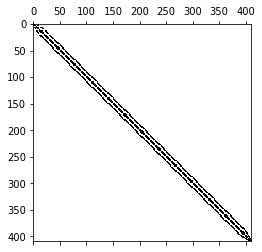

In [16]:
plt.spy(A.array())

## Time discretization

In [17]:
num_functions = 5
functions = [dolfin.Function(V) for i in range(num_functions)]
u, v, a, Ku, Cv = functions
u.rename("u", "u")
u_vec, v_vec, a_vec, Ku_vec, Cv_vec = [func.vector() for func in functions]

In [18]:
times = dt*np.arange(num_steps+1, dtype=np.float64)
displ_tip = np.zeros_like(times)

energies  = np.zeros((num_steps+1, 4), dtype=np.float64)
E_damp    = 0
E_ext     = 0

sig = dolfin.Function(Vsig, name="sigma")
xdmf_file = dolfin.XDMFFile("elastodynamics-results.xdmf")
xdmf_file.parameters["flush_output"]          = True
xdmf_file.parameters["functions_share_mesh"]  = True
xdmf_file.parameters["rewrite_function_mesh"] = False

#### Solve system

In [19]:
u_vec.zero()
v_vec.zero()
a_vec.zero()
Ku_vec.zero()

time_solve = 0.

for n in range(num_steps):
    
    # 1. Predictor step
    
    # u_t = u + dt * v_t +  a_t * (1 - 2*beta) * dt**2 / 2
    u_vec.axpy(dt, v_vec)
    u_vec.axpy((.5 - beta)*dt**2, a_vec)
    
    # v_t = v + a_t * (1 - gamma) * dt 
    v_vec.axpy((1. - gamma)*dt, a_vec)

    # -----
    
    # 2. Update acceleration
    
    traction.t = (n+1)*dt
    f = dolfin.assemble(L(dolfin.TestFunction(V)))
    
    # F_t = F - C v_t - K u_t
    C.mult(v_vec, Cv_vec) 
    K.mult(u_vec, Ku_vec) 
    f.axpy(-1., Cv_vec)
    f.axpy(-1., Ku_vec)
    
    for bc in bcs:
        bc.apply(f)
    
    # -----

    # 3. Solve
    
    t1 = time.perf_counter()
    
    # Solve with  A a_vec = F_t
    # with A = (M + gamma * dt * C + beta * dt**2 * K)
    
    solver.solve(a_vec, f)
    
    t2 = time.perf_counter()
    time_solve += t2 - t1
    
    # -----
    
    # 4. Corrector step
    
    # u = 
    u_vec.axpy(beta*dt**2, a_vec)
    v_vec.axpy(gamma*dt  , a_vec)
    
    # Postprocessing 
    displ_tip[n+1] = u(Lx,0)[1]
    
    E_elas  = dolfin.assemble(0.5*k(u, u))
    E_kin   = dolfin.assemble(0.5*m(v, v))
    E_damp += dt*dolfin.assemble(c(v, v))
    E_tot   = E_elas + E_kin + E_damp
    energies[n+1, :] = np.array([E_elas, E_kin, E_damp, E_tot])
    
    local_project(mesh,stress_strain(strain_displacement(u)), Vsig, sig)

    # Save solution to XDMF format
    xdmf_file.write(u, n)
    xdmf_file.write(sig, n)
    
print(time_solve)

0.00828579998051282


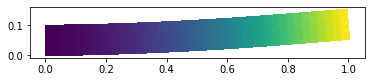

In [20]:
dolfin.plot(u, mode="displacement")

<Figure size 432x288 with 0 Axes>

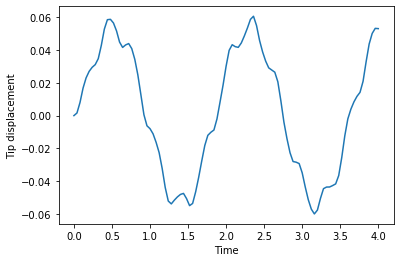

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure()
plt.plot(times, displ_tip, '-')
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.savefig("tip_displacement.png")
plt.figure()

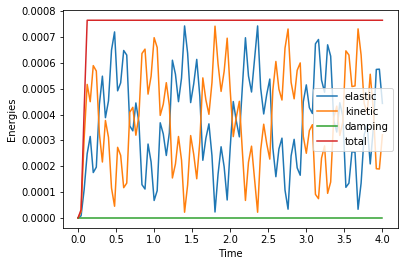

In [22]:
plt.figure()
plt.plot(times, energies)
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()

We recall total energy is a fake total energy : we add elastic to kinetic energy and furthermore add physically dissipated damping energy.

# Questions

Here, we do not consider any physical disspation (eta_m=0, eta_k=0).

1 - We set E=1000, nu=0.3, Lx=1, Ly=0.1, rho=1. What is the period of the oscillations? How does this period change if we (i) divide Lx by 2? (ii) multiply Lx by 2? Compare with the analytical value for an Euler-Bernoulli beam.

2 - Compare the value of the current time step with the critical time step of the Courant condition of the explicit method (dt_crit = mesh.rmin()/np.sqrt(E/rho.values()) for the Courant condition)

3 - Test the case $\gamma < \frac{1}{2}$.

4 - Test the case $\gamma > \frac{1}{2}$ and $2\beta > \gamma$. What is happening ?
 
5 - What happens for low values of t_c like t_c=0.02 ?

6 - Compare the time taken by the computer to (i) solve the linear algebra system at each time step, (ii) write the output files, (iii) execute the rest of the (time-step) loop. Where does the compute spend most time? Which dolfin function is time-consuming? Does this change with parameters?

7 - Write up a python function that perfoms time integration of the system and exports xdmf files to be open with Paraview. The function will take inputs such as Young's modulus, size of the system, time-step, etc.

#### 1. Period of oscillation

$$T = k\times L^2 \times \sqrt{\frac{\rho\times A}{E\times I}}$$ with $k\approx \frac{2\pi}{1.875^2}$.

In [23]:
h = Ly# / Ny #A=h for unit width
w = 1 #unit thickness
A = h*w

I = h**3 / 12
k = 2*np.pi / 1.875**2

T = k * Lx**2 * np.sqrt(rho.values()[0]*A / (E*I))
T

1.9577983008581892

We get back that the period is around 2. It's the period of oscillation of the beam or an element of the beam. If one change the length of the beam :

In [24]:
L_new = 2

T_new = T * (L_new/Lx)**2
T_new

7.8311932034327567

We have a simple multiplication by a factor L_new/L. Let's conclude by comparing to analytical solution :

#### 2. Critical time step

In [25]:
dt_crit = mesh.rmin() / np.sqrt(E / rho.values()[0])
print('\nWe have:\n')
print('dt_crit = {:.4f}s'.format(dt_crit))
print('dt      = {:.2f}s'.format(dt))


We have:

dt_crit = 0.0002s
dt      = 0.04s


We then see we have a higher time step than limit one, which isn't a problem given our values of gamma and beta are consistent with stable case. Indeed, we are in the case where total energy is conserved and scheme is stable, namely we have no dissipation and stability.

As a matter of fact, we force eta_m and eta_n at zero for damping matrix to make sure of energy conservation

By changing the values of gamma and beta, we then expect to reach the limits of implicit method's stability. Let's work on that.